<a href="https://colab.research.google.com/github/Ryan-lra/P12-Applying-Data-Science-/blob/main/NWS_renewed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q plotly pandas numpy ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:00


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# Initial Data Preprocessing
* explicitly for 'GPA_5D_Hyperspreadsheet_Data.csv' dataset
* If using other dataset this cell needs modification

In [ ]:
import os
import sys
import re
import csv
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder

def classify_and_rename(df, id_col='Case'):
    """
    1) Identify columns appearing exactly 3 times (excluding id_col) as base names.
    2) Append suffixes to them: (peak risk), (time of the peak risk), (overall spreading time).
    3) Return renamed DataFrame and categorized variables/Total/isotope column lists.
    """
    header = list(df.columns)
    counts = Counter(header)
    measure_bases = {name for name, cnt in counts.items() if cnt == 3 and name != id_col}

    suffixes = ['(peak risk)', '(time of the peak risk)', '(overall spreading time)']
    counters = {base: 0 for base in measure_bases}

    new_header = []
    for col in header:
        if col in measure_bases:
            idx = counters[col] % 3
            new_header.append(f"{col} {suffixes[idx]}")
            counters[col] += 1
        else:
            new_header.append(col)

    df2 = df.copy()
    df2.columns = new_header

    variables = [
        c for c in new_header
        if c != id_col and not any(c.startswith(base + ' ') for base in measure_bases)
    ]
    total_cols = [c for c in new_header if c.startswith('Total ')]
    isotope_cols = [
        c for c in new_header
        if any(c.startswith(base + ' ') for base in (measure_bases - {'Total'}))
    ]
    return df2, variables, total_cols, isotope_cols

def parse_numeric(val):
    """
    Convert strings with units and comments to float:
    - Remove comments inside parentheses.
    - Support Million/Billion/Thousand suffixes.
    """
    if pd.isna(val):
        return np.nan
    s = str(val).replace(',', '')
    s = re.sub(r'\(.*?\)', '', s).strip()
    m = re.match(r'([0-9]+(?:\.[0-9]+)?(?:[eE][+\-]?[0-9]+)?)\s*([A-Za-z]+)?', s)
    if not m:
        return np.nan
    num = float(m.group(1))
    unit = (m.group(2) or '').lower()
    mult = {'million': 1e6, 'billion': 1e9, 'thousand': 1e3}
    return num * mult.get(unit, 1.0)

def preprocess_variables(df, variables, numeric_vars=('Travel time (T):', 'Flux (Q):')):
    """
    Preprocess the variables:
    - For numeric_vars, apply parse_numeric to convert to float.
    - For others, apply LabelEncoder for categorical encoding.
    Return the processed DataFrame and encoder dictionary.
    """
    encoders = {}
    for col in variables:
        if col in numeric_vars:
            df[col] = df[col].apply(parse_numeric)
        else:
            le = LabelEncoder()
            df[col] = df[col].fillna('Missing').astype(str)
            df[col] = le.fit_transform(df[col])
            encoders[col] = {
                'encoder': le,
                'encoded_values': le.transform(le.classes_),
                'original_values': list(le.classes_)
            }
    return df, encoders

def main(input_file, output_file):
    ext = os.path.splitext(input_file)[-1].lower()

    if ext == '.csv':
        # Auto detect encoding
        encodings = ['utf-8', 'utf-8-sig', 'gbk', 'latin1']
        for enc in encodings:
            try:
                with open(input_file, encoding=enc) as f:
                    f.read(2048)
                print(f"Successfully opened CSV file with encoding {enc}")
                break
            except Exception:
                print(f"Failed to open with encoding {enc}, trying next...")
        else:
            raise UnicodeError(f"Unable to open CSV file with any of encodings: {encodings}")

        # Auto detect delimiter
        with open(input_file, encoding=enc) as f:
            sample = f.read(2048)
            try:
                dialect = csv.Sniffer().sniff(sample)
                delim = dialect.delimiter
            except csv.Error:
                delim = ','

        print(f"Detected delimiter: '{delim}'")

        # Read CSV data
        df_data = pd.read_csv(
            input_file,
            sep=delim,
            header=None,
            skiprows=1,
            dtype=str,
            encoding=enc,
            engine='python'
        )

        # Read header separately
        with open(input_file, encoding=enc, newline='') as f:
            reader = csv.reader(f, delimiter=delim)
            original_header = next(reader)
        df_data.columns = original_header

    elif ext in ('.xlsx', '.xls'):
        print("Detected Excel file, reading...")
        df_tmp = pd.read_excel(input_file, header=None, engine='openpyxl')
        original_header = df_tmp.iloc[0].tolist()
        df_data = pd.read_excel(input_file, header=None, skiprows=1, engine='openpyxl')
        df_data.columns = original_header

    else:
        raise ValueError("Unsupported file format. Only CSV or Excel files are accepted.")

    # Rename and categorize
    df_renamed, variables, total_cols, isotope_cols = classify_and_rename(df_data, id_col='Case')

    # Preprocess variables
    df_processed, label_encoders = preprocess_variables(df_renamed, variables)

    # Fill missing values and save
    df_processed.fillna(0, inplace=True)
    df_processed.to_csv(output_file, index=False, encoding='utf-8-sig')
    print("Data preprocessing complete. Output file saved to:", output_file)

if __name__ == "__main__":
    while True:
        raw = input("Enter input file path (CSV or Excel): ").strip()
        input_file = raw.strip('"').strip("'")
        if os.path.isfile(input_file):
            break
        print(f"File not found: {input_file}. Please re-enter.")

    raw_out = input("Enter output CSV file path: ").strip()
    output_file = raw_out.strip('"').strip("'")
    if not output_file:
        print("Output path cannot be empty. Exiting.")
        sys.exit(1)

    main(input_file, output_file)



<ipython-input-2-53f750b91556>:123: DtypeWarning: Columns (1,2,125) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(input_csv_file, encoding='utf-8-sig')  # Adjust encoding if needed
<ipython-input-2-53f750b91556>:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        1.85e-08
1        1.85e-08
2        1.85e-08
3        1.85e-08
4        1.85e-08
           ...   
16802    1.81e-01
16803    1.81e-01
16804    1.81e-01
16805    1.81e-01
16806    1.81e-01
Name: Total (peak risk), Length: 16807, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[:, i] = df.iloc[:, i].apply(lambda x: '{:.2e}'.format(x) if isinstance(x, (int, float)) and x != 0 else x)
<ipython-input-2-53f750b91556>:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0

Data preprocessing is complete. The final CSV file is saved as: final_Data.csv


## 1. Setup and Data Loading

Import necessary libraries and load the dataset. Define configuration parameters like the input file name and patterns for identifying columns.


In [ ]:
import pandas as pd
import numpy as np
import logging
import re # For regular expressions
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
import plotly.io as pio # Import plotly.io
import traceback # For detailed error reporting

# --- Set Plotly default renderer ---
# Choose the one appropriate for your environment:
# pio.renderers.default = 'colab' # For Google Colab
# pio.renderers.default = 'jupyterlab' # For JupyterLab
# pio.renderers.default = 'notebook' # For classic Jupyter Notebook (needs extensions)
pio.renderers.default = 'plotly_mimetype+notebook' # Often a good default for many environments
# Check if running in Colab and override if necessary
try:
  import google.colab
  pio.renderers.default = 'colab'
  print("Detected Google Colab environment. Setting renderer to 'colab'.")
except ImportError:
  print(f"Using default Plotly renderer: '{pio.renderers.default}'")

# --- Configuration ---
DATA_FILE = 'final_Data.csv'
IDENTIFIER_COLUMN = 'Case' # Column to drop if it exists (case-sensitive)
ISOTOPE_PATTERN = re.compile(r'^[A-Za-z]{1,2}-\d{1,3}m?(?:(?: \(.+?\))|(?:\.\d+))?$')
# --- End Configuration ---

def clean_col_name(col_name):
    """Removes leading/trailing whitespace and trailing colons."""
    name = str(col_name).strip() # Ensure it's a string first
    if name.endswith(':'):
        name = name[:-1].strip()
    return name

print(f"\nAttempting to load data from: {DATA_FILE}")
df = None # Initialize df to None
try:
    df = pd.read_csv(DATA_FILE, low_memory=False)
    print(f"Data loaded successfully. Shape: {df.shape}")
    print("Sample data (first 3 rows):")
    display(df.head(3))
    print("\nInitial DataFrame Info:")
    df.info(verbose=False, memory_usage='deep') # Concise info
except FileNotFoundError:
    print(f"❌ ERROR: File '{DATA_FILE}' not found. Please ensure it's in the same directory as the notebook or provide the full path.")
except Exception as e:
    print(f"❌ ERROR: An error occurred during data loading: {e}")
    traceback.print_exc()


Detected Google Colab environment. Setting renderer to 'colab'.

Attempting to load data from: final_Data.csv
Data loaded successfully. Shape: (16807, 126)
Sample data (first 3 rows):


,Case,Travel time (T):,Flux (Q):,Far-field sorption:,Near-field sorption:,Near-field solubility:,Total (peak risk),Total (time of the peak risk),Total (overall spreading time),H-3 (peak risk),...,Pu-242 (overall spreading time),Am-241 (peak risk),Am-241 (time of the peak risk),Am-241 (overall spreading time),Am-242m (peak risk),Am-242m (time of the peak risk),Am-242m (overall spreading time),Am-243 (peak risk),Am-243 (time of the peak risk),Am-243 (overall spreading time)
0,1,1000000,10,2,2,2,1.850000e-08,2000000.0,4.670000e+11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2,1000000,10,2,2,0,1.850000e-08,2000000.0,4.670000e+11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3,1000000,10,2,2,6,1.850000e-08,2000000.0,4.670000e+11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0



Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16807 entries, 0 to 16806
Columns: 126 entries, Case to Am-243 (overall spreading time)
dtypes: float64(119), int64(6), object(1)
memory usage: 17.0 MB


## 2. Data Preprocessing and Column Identification

Clean column names, attempt numeric conversion, identify isotope and parameter columns based on patterns, and remove columns containing only zeros or missing values.

In [ ]:
isotope_options = []
parameter_options = []

if df is not None:
    print("Starting preprocessing...")
    # 1. Clean column names
    original_columns = df.columns.tolist()
    df.columns = [clean_col_name(col) for col in original_columns]
    print(f"Cleaned {len(original_columns)} column names.")

    # 2. Drop identifier column if it exists
    if IDENTIFIER_COLUMN in df.columns:
        df = df.drop(columns=[IDENTIFIER_COLUMN])
        print(f"Dropped identifier column: '{IDENTIFIER_COLUMN}'")
    else:
        print(f"Identifier column '{IDENTIFIER_COLUMN}' not found, skipping drop.")

    # 3. Convert object columns to numeric where possible
    print("\nAttempting to convert columns to numeric types...")
    converted_count = 0
    conversion_errors = []
    for col in df.select_dtypes(include=['object']).columns:
        # Check if the column *can* be converted before trying, prevents unnecessary warnings for mixed types
        if pd.to_numeric(df[col], errors='coerce').notna().any(): # Check if at least one value could be numeric
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if not df[col].isnull().all():
                    converted_count += 1
            except Exception as e:
                conversion_errors.append((col, str(e)))
                pass # Keep as object if comprehensive conversion fails
        # else: # Optional: Log columns skipped because they seem entirely non-numeric
        #    print(f"  Skipping conversion for object column '{col}' as it likely contains non-numeric data.")

    print(f"Successfully converted {converted_count} object columns to numeric (or they became all NaN)." )
    if conversion_errors:
        print(f"Could not convert {len(conversion_errors)} columns. Examples:")
        for i, (col, err) in enumerate(conversion_errors[:5]):
            print(f"  - '{col}': {err}")
        if len(conversion_errors) > 5:
            print("  ...")

    # 4. Identify isotope columns and parameter columns dynamically
    print("\nIdentifying column types based on naming patterns...")
    all_current_columns = df.columns.tolist()

    for col in all_current_columns:
        # Ensure the column still exists after potential drops/renames
        if col in df.columns:
            if ISOTOPE_PATTERN.match(col):
                isotope_options.append(col)
            else:
                # Assume remaining columns are potential parameters/factors
                parameter_options.append(col)

    print(f"  Identified {len(isotope_options)} potential isotope/metric columns.")
    print(f"  Identified {len(parameter_options)} potential parameter/factor columns.")

    # 5. Drop columns that are entirely NaN or zero AFTER identification & conversion
    print("\nChecking for and removing empty (all NaN or all zero) columns...")
    num_cols_before_drop = len(df.columns)
    cols_to_drop = []
    for col in df.columns:
        try:
            # Check if column is numeric before checking for all zeros
            if pd.api.types.is_numeric_dtype(df[col]):
                # Check if all values are NaN OR if all non-NaN values are 0
                if df[col].isnull().all() or (not df[col].isnull().all() and (df[col].fillna(0) == 0).all()):
                    cols_to_drop.append(col)
            elif df[col].isnull().all(): # Handle non-numeric (object) columns that are all NaN
                cols_to_drop.append(col)
        except Exception as e:
             print(f"  Warning: Error checking column '{col}' for removal: {e}. Skipping this column.")

    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)
        print(f"  Dropped {len(cols_to_drop)} columns: {', '.join(cols_to_drop)}")
        # Update option lists after dropping columns
        isotope_options = [col for col in isotope_options if col in df.columns]
        parameter_options = [col for col in parameter_options if col in df.columns]
        print(f"  Updated isotope options: {len(isotope_options)} remaining.")
        print(f"  Updated parameter options: {len(parameter_options)} remaining.")
    else:
      print("  No columns found to be entirely zero or NaN.")

    # 6. Final check and info
    print("\nFinal DataFrame Info after preprocessing:")
    df.info(verbose=False, memory_usage='deep')
    print("\nSample data after preprocessing:")
    display(df.head(3))

    # 7. Sort options for consistent dropdown order
    isotope_options.sort()
    parameter_options.sort()
    print("\nPreprocessing finished.")
    if not isotope_options or not parameter_options:
        print("⚠️ WARNING: Either isotope or parameter options list is empty. Plotting will likely fail.")
    else:
        print(f"✅ Ready for plotting with {len(isotope_options)} isotopes/metrics and {len(parameter_options)} parameters.")

else:
    print("❌ DataFrame could not be loaded. Cannot perform preprocessing.")

Starting preprocessing...
Cleaned 126 column names.
Dropped identifier column: 'Case'

Attempting to convert columns to numeric types...
Successfully converted 1 object columns to numeric (or they became all NaN).

Identifying column types based on naming patterns...
  Identified 117 potential isotope/metric columns.
  Identified 8 potential parameter/factor columns.

Checking for and removing empty (all NaN or all zero) columns...
  Dropped 6 columns: H-3 (peak risk), H-3 (time of the peak risk), H-3 (overall spreading time), Pu-241 (peak risk), Pu-241 (time of the peak risk), Pu-241 (overall spreading time)
  Updated isotope options: 111 remaining.
  Updated parameter options: 8 remaining.

Final DataFrame Info after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16807 entries, 0 to 16806
Columns: 119 entries, Travel time (T) to Am-243 (overall spreading time)
dtypes: float64(114), int64(5)
memory usage: 15.3 MB

Sample data after preprocessing:


,Travel time (T),Flux (Q),Far-field sorption,Near-field sorption,Near-field solubility,Total (peak risk),Total (time of the peak risk),Total (overall spreading time),Be-10 (peak risk),Be-10 (time of the peak risk),...,Pu-242 (overall spreading time),Am-241 (peak risk),Am-241 (time of the peak risk),Am-241 (overall spreading time),Am-242m (peak risk),Am-242m (time of the peak risk),Am-242m (overall spreading time),Am-243 (peak risk),Am-243 (time of the peak risk),Am-243 (overall spreading time)
0,1000000,10,2,2,2,1.850000e-08,2000000.0,4.670000e+11,3.110000e-12,2000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000000,10,2,2,0,1.850000e-08,2000000.0,4.670000e+11,3.110000e-12,2000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000000,10,2,2,6,1.850000e-08,2000000.0,4.670000e+11,3.110000e-12,2000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Preprocessing finished.
✅ Ready for plotting with 111 isotopes/metrics and 8 parameters.


# 3. User Interface for Selection

Select an isotope metric (Z-axis and Heatmap value) and three distinct parameters:
*   Parameter 1: X-axis
*   Parameter 2: Y-axis
*   Parameter 3: Color scale for the Surface Plot

In [ ]:
# Check if df exists and options were successfully populated before creating widgets
if 'df' in locals() and df is not None and isotope_options and parameter_options:

    # --- Widget Creation ---
    style = {'description_width': 'initial'}
    layout = widgets.Layout(width='95%')

    selected_isotope = widgets.Dropdown(
        options=isotope_options,
        description='Isotope/Metric (Z-axis & Heatmap):',
        disabled=False,
        style=style,
        layout=layout
    )

    selected_parameter1 = widgets.Dropdown(
        options=parameter_options,
        description='Parameter 1 (X-axis):',
        disabled=False,
        style=style,
        layout=layout
    )

    selected_parameter2 = widgets.Dropdown(
        options=parameter_options,
        description='Parameter 2 (Y-axis):',
        disabled=False,
        style=style,
        layout=layout
    )

    selected_parameter3 = widgets.Dropdown(
        options=parameter_options,
        description='Parameter 3 (Surface Color):',
        disabled=False,
        style=style,
        layout=layout
    )

    # --- Default Selection Logic ---
    def find_default(keywords, options, fallback_index):
        for kw in keywords:
            match = next((opt for opt in options if kw in opt.lower()), None)
            if match: return match
        if fallback_index < len(options):
            return options[fallback_index]
        elif options:
            return options[0]
        return None

    default_p1 = find_default(['travel time'], parameter_options, 0)
    default_p2 = find_default(['flux'], parameter_options, 1)
    default_p3 = find_default(['total', 'spreading'], parameter_options, 2)
    default_iso = find_default(['ni-59', 'overall'], isotope_options, 0)

    if len(parameter_options) > 1 and default_p1 == default_p2:
        if parameter_options[1] != default_p1:
            default_p2 = parameter_options[1]
        elif len(parameter_options) > 2 and parameter_options[0] != default_p2:
            default_p1 = parameter_options[0]

    if default_p1: selected_parameter1.value = default_p1
    if default_p2: selected_parameter2.value = default_p2
    if default_p3: selected_parameter3.value = default_p3
    if default_iso: selected_isotope.value = default_iso

    # --- Output Areas ---
    output_messages = widgets.Output()
    output_surface = widgets.Output()
    output_heatmap = widgets.Output()
    output_3dbar = widgets.Output()
    output_line = widgets.Output()
    output_parallel = widgets.Output()


    # --- Plot Functions ---
    def generate_surface_plot(df_pivot, x_vals, y_vals, z_col, color_col, p1_name, p2_name):
        color_pivot = pd.pivot_table(df_pivot, values=color_col, index=p2_name, columns=p1_name, aggfunc='mean')
        z_pivot_data = pd.pivot_table(df_pivot, values=z_col, index=p2_name, columns=p1_name, aggfunc='mean')
        z_pivot_data = z_pivot_data.reindex(index=y_vals, columns=x_vals)
        color_pivot = color_pivot.reindex(index=y_vals, columns=x_vals)

        fig_surface = go.Figure(data=[go.Surface(
            x=x_vals,
            y=y_vals,
            z=z_pivot_data.values,
            surfacecolor=color_pivot.values,
            colorscale='Viridis',
            colorbar_title=color_col,
            showscale=True,
            hovertemplate=f'<b>{p1_name}</b>: %{{x}}<br>' +
                          f'<b>{p2_name}</b>: %{{y}}<br>' +
                          f'<b>{z_col}</b>: %{{z:.3e}}<br>' +
                          f'<b>{color_col}</b>: %{{surfacecolor:.3e}}' +
                          '<extra></extra>'
        )])

        fig_surface.update_layout(
            title=f"Surface Plot: {z_col} vs ({p1_name}, {p2_name})<br><i>Color Mapped to {color_col}</i>",
            scene=dict(
                xaxis_title=p1_name,
                yaxis_title=p2_name,
                zaxis_title=z_col,
                aspectmode='cube'
            ),
            height=500,
            width=1000,
            margin=dict(l=10, r=10, b=10, t=60)
        )
        fig_surface.show()
        #print("✅ Surface Plot generated.")
        return True

    def generate_heatmap(df_data, x_col, y_col, z_col, use_pivot=False, x_vals=None, y_vals=None):
        if use_pivot and x_vals is not None and y_vals is not None:
            z_pivot = pd.pivot_table(df_data, values=z_col, index=y_col, columns=x_col, aggfunc='mean')
            z_pivot = z_pivot.reindex(index=y_vals, columns=x_vals)
            z_data = z_pivot.values
            x_data = z_pivot.columns.astype(str)
            y_data = z_pivot.index.astype(str)
            title_suffix = "(Grid View - Averaged Values)"
        else:
            z_data = df_data[z_col]
            x_data = df_data[x_col].astype(str)
            y_data = df_data[y_col].astype(str)
            title_suffix = "(Direct Data View - May Overlap)"

        fig_heatmap = go.Figure(data=go.Heatmap(
            z=z_data,
            x=x_data,
            y=y_data,
            colorscale='Blues',
            colorbar=dict(title=z_col),
            hovertemplate=f'<b>{x_col}</b>: %{{x}}<br>' +
                          f'<b>{y_col}</b>: %{{y}}<br>' +
                          f'<b>{z_col}</b>: %{{z:.3e}}<extra></extra>',
            xgap=1, ygap=1
        ))

        fig_heatmap.update_layout(
            title=f"Heatmap: {z_col} vs ({x_col}, {y_col}) {title_suffix}",
            xaxis_title=x_col,
            yaxis_title=y_col,
            xaxis_type='category',
            yaxis_type='category',
            height=500,
            width=1000,
            margin=dict(l=40, r=40, b=80, t=80),
            xaxis={'tickangle': 45}
        )
        fig_heatmap.show()
        #print("✅ Heatmap generated.")
        return True

    def generate_3d_bar_chart(df_data, x_col, y_col, z_col, bar_width=1.0):
        import plotly.colors as pc

        grouped = df_data.groupby([x_col, y_col])[z_col].mean().reset_index()

        x_mapping = {v: i for i, v in enumerate(sorted(grouped[x_col].unique()))}
        y_mapping = {v: i for i, v in enumerate(sorted(grouped[y_col].unique()))}

        grouped['x_num'] = grouped[x_col].map(x_mapping)
        grouped['y_num'] = grouped[y_col].map(y_mapping)

        vertices = []
        i = []
        j = []
        k = []
        vertex_colors = []

        viridis = pc.get_colorscale('Viridis')

        if not grouped[z_col].empty:
            h_min, h_max = grouped[z_col].min(), grouped[z_col].max()
            def normalize(val):
                if h_max - h_min == 0:
                    return 0.5
                return (val - h_min) / (h_max - h_min)
        else:
            def normalize(val):
                return 0.5

        for idx, row in grouped.iterrows():
            x = row['x_num']
            y = row['y_num']
            h = row[z_col]

            x0, x1 = x - bar_width/2, x + bar_width/2
            y0, y1 = y - bar_width/2, y + bar_width/2
            z0, z1 = 0, h

            cube_vertices = [
                (x0, y0, z0), (x1, y0, z0), (x1, y1, z0), (x0, y1, z0),
                (x0, y0, z1), (x1, y0, z1), (x1, y1, z1), (x0, y1, z1)
            ]

            offset = len(vertices)
            vertices.extend(cube_vertices)

            faces = [
                (0,1,2), (0,2,3),
                (4,5,6), (4,6,7),
                (0,1,5), (0,5,4),
                (1,2,6), (1,6,5),
                (2,3,7), (2,7,6),
                (3,0,4), (3,4,7)
            ]

            for tri in faces:
                i.append(tri[0] + offset)
                j.append(tri[1] + offset)
                k.append(tri[2] + offset)

            color_val = normalize(h)
            vertex_colors.extend([color_val] * 8)

        if not vertices:
            print("⚠️ No data available for 3D Bar Chart.")
            return False

        x_mesh, y_mesh, z_mesh = zip(*vertices)

        fig = go.Figure(
            data=[
                go.Mesh3d(
                    x=x_mesh,
                    y=y_mesh,
                    z=z_mesh,
                    i=i,
                    j=j,
                    k=k,
                    intensity=vertex_colors,
                    colorscale='Viridis',
                    colorbar_title=z_col,
                    flatshading=True,
                    showscale=True,
                    opacity=0.9
                )
            ]
        )

        fig.update_layout(
            title=f"3D Bar Chart (Gradient): Mean {z_col} over {x_col} and {y_col}",
            scene=dict(
              xaxis=dict(
                    title=x_col,
                    tickmode='array',
                    tickvals=list(x_mapping.values()),
                    ticktext=list(x_mapping.keys())
                ),
                yaxis=dict(
                    title=y_col,
                    tickmode='array',
                    tickvals=list(y_mapping.values()),
                    ticktext=list(y_mapping.keys())
                ),
                zaxis=dict(
                    title=f"Mean {z_col}"
                ),
                aspectmode='cube'
            ),
            height=700,
            width=1000,
            margin=dict(l=20, r=20, b=20, t=60)
        )

        fig.show()
        return True


    def generate_line_chart(df_data, x_col, y_col, z_col):
      grouped = df_data.groupby([x_col, y_col])[z_col].mean().reset_index()
      pivot = grouped.pivot(index=x_col, columns=y_col, values=z_col)

      fig_line = go.Figure()

      colors = ['#0F4C81', '#1B6CA8', '#2892D7', '#52B2CF', '#77C9D4',
                '#3D5A80', '#2E8BC0', '#145DA0', '#126E82', '#394867']

      for i, col in enumerate(pivot.columns):
          fig_line.add_trace(go.Scatter(
              x=pivot.index.astype(str),
              y=pivot[col],
              mode='lines+markers',
              name=str(col),
              line=dict(color=colors[i % len(colors)], width=2),
              marker=dict(size=6)
          ))

      fig_line.update_layout(
          title=f"Line Chart: Mean {z_col} over {x_col} grouped by {y_col}",
          xaxis_title=x_col,
          yaxis_title=f"Mean {z_col}",
          height=500,
          width=1000,
          margin=dict(l=40, r=40, b=60, t=60)
      )

      fig_line.show()
      return True
    import plotly.express as px

    def generate_parallel_coordinates(df_data, cols, color_col=None):
      df_plot = df_data[cols].copy()

      for col in cols:
          if not pd.api.types.is_numeric_dtype(df_plot[col]):
              df_plot[col] = pd.Categorical(df_plot[col]).codes

      if color_col and color_col in df_plot.columns:
          color_vals = df_plot[color_col]
      else:
          color_vals = None

      fig_parallel = px.parallel_coordinates(
          df_plot,
          dimensions=cols,
          color=color_vals,
          color_continuous_scale='Viridis',
          labels={col: col for col in cols}
    )

      fig_parallel.update_layout(
          title="Parallel Coordinates Plot",
          height=500,
          width=1000,
          margin=dict(l=40, r=40, b=60, t=60)
      )

      fig_parallel.show()
      return True


    # --- Button and Callback ---
    submit_button = widgets.Button(description="Generate Plots", button_style='info', icon='check')

    def on_submit_clicked(b):
        output_messages.clear_output(wait=True)
        output_surface.clear_output(wait=True)
        output_heatmap.clear_output(wait=True)
        output_3dbar.clear_output(wait=True)
        output_line.clear_output(wait=True)
        output_parallel.clear_output(wait=True)

        with output_messages:
            print("⏳ Processing selection...")

        isotope_col = selected_isotope.value
        param1_col = selected_parameter1.value
        param2_col = selected_parameter2.value
        param3_col = selected_parameter3.value

        valid = True
        if not isotope_col or not (param1_col and param2_col and param3_col):
            with output_messages:
                clear_output(wait=True)
                print("❌ ERROR: Please select all required fields.")
            valid = False
        elif param1_col == param2_col:
            with output_messages:
                clear_output(wait=True)
                print("❌ ERROR: Parameter 1 and Parameter 2 must be different.")
            valid = False

        if not valid:
            return

        with output_messages:
            clear_output(wait=True)
            print("📊 Selections:")
            print(f"  Isotope/Metric: {isotope_col}")
            print(f"  Parameter 1 (X): {param1_col}")
            print(f"  Parameter 2 (Y): {param2_col}")
            print(f"  Parameter 3 (Color): {param3_col}")
            print("\n⏳ Preparing data...")

        cols_needed = list(set([param1_col, param2_col, isotope_col, param3_col]))
        df_plot = df[cols_needed].copy()
        for col in cols_needed:
            if not pd.api.types.is_numeric_dtype(df_plot[col]):
                df_plot[col] = pd.to_numeric(df_plot[col], errors='coerce')

        df_plot.dropna(inplace=True)
        if df_plot.empty:
            with output_messages:
                print("⚠️ No data left after removing NaNs.")
            return

        df_plot = df_plot.sort_values(by=[param1_col, param2_col])
        x_vals = np.sort(df_plot[param1_col].unique())
        y_vals = np.sort(df_plot[param2_col].unique())
        can_pivot = len(x_vals) >= 2 and len(y_vals) >= 2

        with output_surface:
            if can_pivot:
                try:
                    generate_surface_plot(df_plot, x_vals, y_vals, isotope_col, param3_col, param1_col, param2_col)
                except Exception as e:
                    with output_messages:
                        print(f"❌ Error generating surface plot: {e}")
            else:
                with output_messages:
                    print("ℹ️ Skipping surface plot due to insufficient grid.")

        with output_heatmap:
            try:
                generate_heatmap(df_plot, param1_col, param2_col, isotope_col, use_pivot=can_pivot, x_vals=x_vals, y_vals=y_vals)
            except Exception as e:
                with output_messages:
                    print(f"❌ Error generating heatmap: {e}")

        with output_messages:
            print("\n✅ Plot generation finished.")

        with output_3dbar:
            try:
                generate_3d_bar_chart(df_plot, param1_col, param2_col, isotope_col)
            except Exception as e:
                with output_messages:
                    print(f"❌ Error generating 3D bar chart: {e}")

        with output_line:
            try:
                generate_line_chart(df_plot, param1_col, param2_col, isotope_col)
            except Exception as e:
                with output_messages:
                    print(f"❌ Error generating line chart: {e}")

        with output_parallel:
            try:
                generate_parallel_coordinates(df_plot, [param1_col, param2_col, param3_col, isotope_col], color_col=isotope_col)
            except Exception as e:
                with output_messages:
                    print(f"❌ Error generating parallel coordinates plot: {e}")

    submit_button.on_click(on_submit_clicked)

    # --- Display Interface ---
    ui = widgets.VBox([
        widgets.HTML("<b>Select Isotope and Parameters:</b>"),
        selected_isotope,
        selected_parameter1,
        selected_parameter2,
        selected_parameter3,
        submit_button,
        widgets.HTML("<hr><b>Messages:</b>"),
        output_messages,
        widgets.HTML("<hr><b>Surface Plot:</b>"),
        output_surface,
        widgets.HTML("<hr><b>Heatmap:</b>"),
        output_heatmap,
        widgets.HTML("<hr><b>3D Bar Chart:</b>"),
        output_3dbar,
        widgets.HTML("<hr><b>Line Chart:</b>"),
        output_line,
        widgets.HTML("<hr><b>Parallel Coordinates Plot:</b>"),
        output_parallel
    ])
    display(ui)

else:
    if 'df' not in locals() or df is None:
        print("❌ ERROR: Data not loaded.")
    elif not isotope_options:
        print("❌ ERROR: No isotope/metric columns found.")
    elif not parameter_options:
        print("❌ ERROR: No valid parameter columns found.")
    else:
        print("❌ ERROR: Unexpected initialization issue.")




## Static Visualisation

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
# Static Analysis Function Definitions

# 2) Correlation: Parameters vs Per‑Nuclide Peak Risk
def plot_param_nuclide_correlation(df, params):
    pr_cols = [c for c in df.columns if c.endswith('(peak risk)')]
    corr = df[params + pr_cols].corr().loc[params, pr_cols]
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Input Parameters vs Per‑Nuclide Peak Risk Correlation')
    plt.xlabel('Nuclides')
    plt.ylabel('Parameters')
    plt.tight_layout()
    plt.show()

# 3) Feature Importance (2D Bar Chart)
def plot_feature_importance(df, feature_cols, target_col):
    df_clean = df[feature_cols + [target_col]].dropna()
    if df_clean.empty:
        print(f"⚠️ Skipped {target_col}: No valid data.")
        return
    X_df = df_clean[feature_cols]
    y = df_clean[target_col]
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_df.values, y)
    importances = rf.feature_importances_
    idx = np.argsort(importances)[::-1]
    feature_names = list(X_df.columns)
    plt.figure(figsize=(10, 5))
    plt.barh([feature_names[i] for i in idx], importances[idx], color="orange", align="center")
    plt.gca().invert_yaxis()
    plt.xlabel("Relative Importance")
    plt.title("2D Bar Chart: Variable Importance (Random Forest)")
    plt.show()


In [ ]:
# —— New independent Cell: Static Analysis UI ——
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# 1) Create the button and output container
static_button = widgets.Button(
    description="Run Static Analysis",
    button_style="warning",
    tooltip="Click to generate all static plots"
)
output_static = widgets.Output()

# 2) Button callback: run all static plots without any further selection
def on_static_clicked(b):
    output_static.clear_output(wait=True)
    with output_static:
        # Dynamically gather all numeric feature columns
        feats = [
            c for c in parameter_options
            if c in df.columns and pd.api.types.is_numeric_dtype(df[c])
        ]
        if not feats:
            print("⚠️ No numeric features found.")
            return

        # ② Correlation Matrix between parameters and per‑nuclide peak risk
        print("\n🔍 Param vs Per‑Nuclide Risk Correlation")
        plot_param_nuclide_correlation(df, feats)

# 3) Wire up and display the UI
static_button.on_click(on_static_clicked)
display(widgets.VBox([static_button, output_static]))


In [ ]:
 # ③ Random Forest Feature Importance
 # Create a standalone cell for Isotope-Specific Feature Importance UI

# 2) Widgets: isotope selector + button
isotope_selector = widgets.SelectMultiple(
    options=isotope_options,
    description='Isotopes:',
    layout=widgets.Layout(width='70%', height='200px')
)

run_button = widgets.Button(description='Run Feature Importance', button_style='info')
output_feature_importance = widgets.Output()

# 3) Callback
def on_run_clicked(b):
    output_feature_importance.clear_output(wait=True)
    with output_feature_importance:
        selected_isotopes = list(isotope_selector.value)
        if not selected_isotopes:
            print("⚠️ Please select at least one isotope.")
            return

        feats = [
            c for c in parameter_options
            if c in df.columns and pd.api.types.is_numeric_dtype(df[c])
        ]

        if not feats:
            print("⚠️ No numeric feature columns found.")
            return

        for iso_col in selected_isotopes:
            print(f"\n▶ Feature Importance for: {iso_col}")
            plot_feature_importance(df, feats, iso_col)

# 4) Wire up and display
run_button.on_click(on_run_clicked)

display(widgets.VBox([
    widgets.HTML("<b>Select Isotopes to analyze feature importance:</b>"),
    isotope_selector,
    run_button,
    output_feature_importance
]))


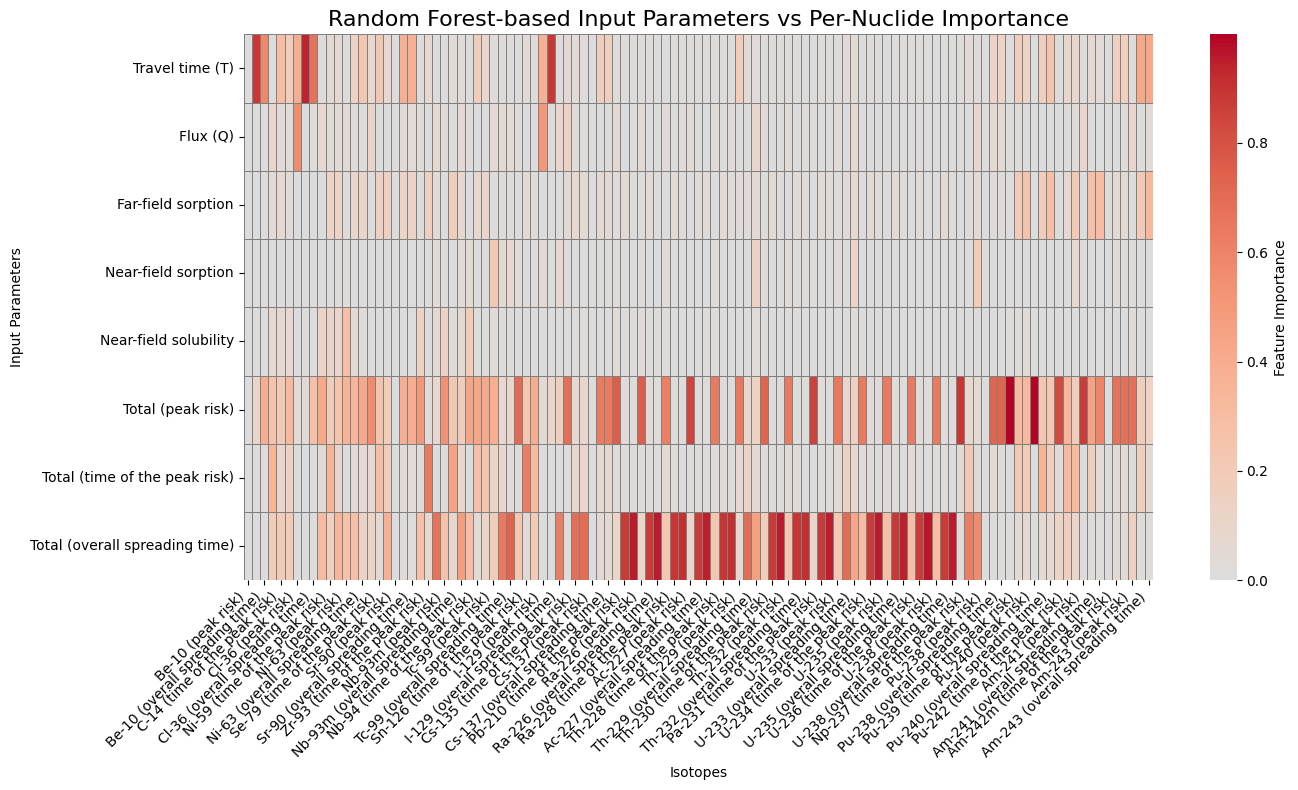

In [ ]:
# — Random Forest-based Per-Nuclide Importance —
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 0) Define your parameter and isotope columns
import re
ISOTOPE_PATTERN = re.compile(r'^[A-Za-z]{1,2}-\d{1,3}m?(?:(?: \(.+?\))|(?:\.\d+))?$')

parameter_options = [
    col for col in df.columns
    if pd.api.types.is_numeric_dtype(df[col]) and not ISOTOPE_PATTERN.match(col)
]

isotope_options = [
    col for col in df.columns
    if pd.api.types.is_numeric_dtype(df[col]) and ISOTOPE_PATTERN.match(col)
]

# 1) Build Importance Matrix
importance_matrix = pd.DataFrame(index=parameter_options, columns=isotope_options)

for iso in isotope_options:
    df_iso = df[parameter_options + [iso]].dropna()
    if len(df_iso) < 20:
        print(f"⚠️ Skipping {iso} (too few samples)")
        continue

    X = df_iso[parameter_options]
    y = df_iso[iso]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X.values, y)

    importance_matrix[iso] = rf.feature_importances_

importance_matrix = importance_matrix.astype(float)

# 2) Plot Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    importance_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Feature Importance'}
)
plt.title('Random Forest-based Input Parameters vs Per-Nuclide Importance', fontsize=16)
plt.xlabel('Isotopes')
plt.ylabel('Input Parameters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# — Multi-Param Contour Selector UI (X, Y, Z as dropdowns) —
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Automatic detection of parameter & isotope columns
import re

ISOTOPE_PATTERN = re.compile(r'^[A-Za-z]{1,2}-\d{1,3}m?(?:(?: \(.+?\))|(?:\.\d+))?$')

parameter_options = [
    col for col in df.columns
    if pd.api.types.is_numeric_dtype(df[col]) and not ISOTOPE_PATTERN.match(col)
]

isotope_options = [
    col for col in df.columns
    if pd.api.types.is_numeric_dtype(df[col]) and ISOTOPE_PATTERN.match(col)
]


# 1) Identify numeric columns
feats = [
    c for c in parameter_options
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c])
]

z_options = ['Total (peak risk)'] + isotope_options

# 2) Widgets: X, Y, Z dropdowns
x_dropdown = widgets.Dropdown(options=feats, description='X Parameter:')
y_dropdown = widgets.Dropdown(options=feats, description='Y Parameter:')
z_dropdown = widgets.Dropdown(options=z_options, description='Z (Colour):')

plot_button = widgets.Button(description='Plot Contour', button_style='info')
out_contour = widgets.Output()

# 3) Callback
def on_plot_click(b):
    out_contour.clear_output(wait=True)
    with out_contour:
        xcol, ycol, zcol = x_dropdown.value, y_dropdown.value, z_dropdown.value

        if xcol == ycol:
            print("⚠️ X and Y must be different.")
            return

        df_tmp = df[[xcol, ycol, zcol]].dropna()

        # Safe bounds for log bins
        def safe_bounds(series):
            series = series.replace(0, np.nan).dropna()
            if len(series) == 0:
                return (1e-6, 1e-5)
            return (series.min(), series.max())

        xmin, xmax = safe_bounds(df_tmp[xcol])
        ymin, ymax = safe_bounds(df_tmp[ycol])

        # Use log-spaced bins
        x_edges = np.logspace(np.log10(xmin), np.log10(xmax), 31)
        y_edges = np.logspace(np.log10(ymin), np.log10(ymax), 31)

        df_tmp['x_bin'] = pd.cut(df_tmp[xcol], bins=x_edges, include_lowest=True)
        df_tmp['y_bin'] = pd.cut(df_tmp[ycol], bins=y_edges, include_lowest=True)

        grid = (
            df_tmp
            .groupby(['y_bin','x_bin'], observed=True)[zcol]
            .mean()
            .unstack(fill_value=np.nan)
        )

        x_centers = (x_edges[:-1] + x_edges[1:]) / 2
        y_centers = (y_edges[:-1] + y_edges[1:]) / 2

        fig = go.Figure(
            go.Contour(
                z=grid.values,
                x=x_centers,
                y=y_centers,
                colorscale='Viridis',
                contours=dict(showlabels=True, labelfont_size=12),
                colorbar=dict(title=f'Mean {zcol}')
            )
        )
        fig.update_layout(
            title=f"Contour: {zcol} vs {xcol}, {ycol}",
            xaxis_title=xcol,
            yaxis_title=ycol,
            width=700,
            height=600
        )
        fig.show()

# 4) UI Layout & Display
plot_button.on_click(on_plot_click)
display(widgets.VBox([
    widgets.HTML("<b>Select X, Y parameters and Z target:</b>"),
    x_dropdown, y_dropdown, z_dropdown,
    plot_button, out_contour
]))
